# Preprocessing

## Install / Import all Python Modules Required

In [ ]:
! pip install contractions

In [ ]:
! pip install python-dotenv

In [ ]:
! pip install nltk

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


from dotenv import load_dotenv, find_dotenv
import os

2022-12-10 12:37:28.182423: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-10 12:37:28.182520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
pd.set_option('display.max_colwidth', None)

## Load the Datasets required (Train Set, Validation Set, Test Set)

In [3]:
# #loading the datasets
# train_set = pd.read_csv('../raw_data/train.csv')
# validation_set = pd.read_csv('../raw_data/validation.csv')
# test_set = pd.read_csv('../raw_data/test.csv')

In [4]:
from brief_news.data.big_query import get_bq_chunk

train_set = get_bq_chunk('train', 0, 100)
validation_set = get_bq_chunk('validation', 0, 100)
test_set = get_bq_chunk('test', 0, 100)

In [5]:
len(train_set)

100

## Drop Useless Columns

In [6]:
# droppping useless columns
train_data = train_set.drop(['id', 'orig_id'], axis=1)[:5000]
val_data = validation_set.drop(['id', 'orig_id'], axis=1)[:200]
test_data = test_set.drop(['id', 'orig_id'], axis=1)[:100]

In [7]:
train_data.shape

(100, 2)

In [8]:
train_data[6:8]

article  \
6                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          KARBALA, Iraq (CNN) -- A female suicide bomber apparently targeting Shiite worshippers killed at least 40 people and wounded at least 65 in Karbala on Monday, according to an Interior Ministry official. Iraqi security forces gather around the site of a car bomb explosion in Baghdad on Monday. The incident occurred one-half mile from the Imam Hussein shrine of Karbala. Karbala is a Shiite holy city, and the Imam Hussein shrine is one of Shiite Islam's holiest locations. The shrine marks the burial spot of Hussein bin Ali, the grandson of the Prophet Mohammed, who was killed in battle nearby in 680. No more information was immediately available about the blast southwest of the capital city, Baghdad. Earlier Monday, in Baghdad, a roadside bomb exploded near an Iraqi police patrol, killing one officer and wounding another, the Interior Ministry told CNN. A short time later, another roadside bomb exploded near an Iraqi police patrol on Palestine Street in eastern Baghdad, wounding four bystan

In [9]:
print(f"train_data.shape: {train_data.shape}")

train_data.shape: (100, 2)


## Check if there are any Empty Cells in the DataFrame

In [10]:
train_data.isna().sum()

article       0
highlights    0
dtype: int64

In [11]:
test_data.isna().sum()

article       0
highlights    0
dtype: int64

## Dealing with Duplicates / Drop Duplicates in the Train, Validation and Test Sets

In [12]:
train_data.duplicated(subset=['article', 'highlights']).sum()

0

In [13]:
val_data.duplicated(subset=['article', 'highlights']).sum()

0

In [14]:
test_data.duplicated(subset=['article', 'highlights']).sum()

0

In [15]:
def del_duplicates(dataset, columns_to_compare):
    '''
    Function that deletes duplicated lines comapres according to indicated columns
    '''
    return dataset.drop_duplicates(subset=columns_to_compare)

In [16]:
cols = ['article', 'highlights']

train = del_duplicates(train_data, columns_to_compare=cols)
train.shape

(100, 2)

In [17]:
val = del_duplicates(val_data, columns_to_compare=cols)
val.shape

(100, 2)

In [18]:
test = del_duplicates(test_data, columns_to_compare=cols)
test.shape

(100, 2)

## Potential threshhold for news extraction / Check the Statistical Distribution of Word Counts for Articles and Summaries

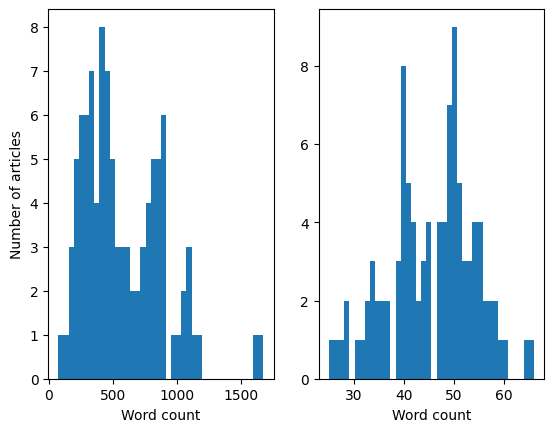

In [19]:
# word count
article_wc = []
summary_wc = []

# populate the lists with sentence lengths
for i in train.article:
      article_wc.append(len(i.split()))

for i in train.highlights:
      summary_wc.append(len(i.split()))

length_df = pd.DataFrame({'text':article_wc, 'summary':summary_wc})

plt.subplot(1, 2, 1)
plt.hist(length_df.text, bins=40)
plt.xlabel("Word count")
plt.ylabel("Number of articles")


plt.subplot(1, 2, 2)
plt.hist(length_df.summary, bins=40)
plt.xlabel("Word count")


plt.show()

## Clean the Data

### Prepare a Function "Preprocessing" to perform the single cleaning steps

- Transform upper cases to lower cases
- Remove return characters, url and html tags
- Expand shortened words via Contractions
- Remove any parentheses with text inside
- Remove special characters, remove whitespaces

In [20]:
def preprocessing(sentence: string, remove_stopwords=True) -> string: 
    
    '''
    Preprocessing text: lower case, 
                        deleting punctuation, 
                        replacing contructions with equivalent,
                        deleting stop words,
                        removing special characters
    '''

    # Lowercase
    sentence = sentence.lower()
   
    # Remove return characters, url and html tags
    code_list = ['\n', '\S*(http|https)\S*', '\<a href', '&amp;', '<br />']
    for code in code_list:
        sentence = re.sub(code, ' ',sentence, flags=re.MULTILINE)
    
    # expand the shortened words (can't => can not)
    # after they will be deleted in stopwords
    expanded = []   
    for word in sentence.split():
        expanded.append(contractions.fix(word, slang=False))
        
    expanded_sentence = ' '.join(expanded)
    
    # remove any parenthisis with text inside
    sentence = re.sub(r'\([^)]*\)', '', expanded_sentence)
        # Removing punctuation, url and html tags
    for punctuation in string.punctuation + '[\'\"]':
        sentence = sentence.replace(punctuation, ' ')
        
    # remove special characters 
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    # Removing whitespaces
    sentence = sentence.strip()
                
    if remove_stopwords:
        stop_words = set(stopwords.words('english')) ## defining stopwords    
        sentence_list = [w for w in sentence.split() if not w in stop_words]
        sentence = (' '.join(sentence_list)).strip()
        
    return sentence

### Test the function "Preprocessing" prepared to clean the data on a subset to check if it works

In [21]:
def cleaning(dataset: pd.Series, remove_stopwords=True) -> list:
    '''
    This function creates a cleaned version of each dataset.
    Calls the preprocessing function.
    '''
    
    clean = []
    for text in dataset:
        clean.append(preprocessing(text, remove_stopwords=True))
    return clean

In [22]:
%%time

X_train = cleaning(train.article)
y_train = cleaning(train.highlights, remove_stopwords=False)

CPU times: user 209 ms, sys: 0 ns, total: 209 ms
Wall time: 206 ms


In [23]:
print(f'Clean article : {X_train[0]}')
print('\n')
print(f'Clean summary : {y_train[0]}')

Clean article : football superstar celebrity fashion icon multimillion dollar heartthrob david beckham headed hollywood hills takes game u major league soccer cnn looks bekham fulfilled dream playing manchester united time playing england world famous footballer begun five year contract los angeles galaxy team friday beckham meet press reveal new shirt number week take depth look life times beckham cnn becks becky anderson sets examine makes man tick footballer fashion icon global phenomenon long way streets east london hollywood hills becky charts beckham incredible rise football stardom journey seen skills grace greatest stages world soccer goes pursuit current hottest property sports celebrity circuit u along way explores exactly behind man golden boot cnn look back life beckham wonderfully talented youngster fulfilled dream playing manchester united marriage pop star victoria trials tribulations playing england look highs lows man u departure galacticos madrid home depot stadium l 

In [24]:
%%time

X_val = cleaning(val.article)
y_val = cleaning(val.highlights, remove_stopwords=False)

CPU times: user 294 ms, sys: 0 ns, total: 294 ms
Wall time: 291 ms


In [25]:
%%time

X_test = cleaning(test.highlights, remove_stopwords=False)
y_test = cleaning(test.article)

CPU times: user 229 ms, sys: 0 ns, total: 229 ms
Wall time: 225 ms


### !!! Only for target data => adding "start" and "stop" to the sequence

In [26]:
def adding_decoder_tokens(data: pd.Series) -> pd.Series:
    '''
    Adding special tokens for the decoder only to target string
    '''
    
    return pd.Series(data).apply(lambda x : '_START_ '+ x + ' _END_')

y_train = adding_decoder_tokens(y_train)
y_val = adding_decoder_tokens(y_val)

In [27]:
y_train[0]

'_START_ beckham agreed five year contract los angeles galaxy new contract took effect july former english captain meet press unveil new shirt number friday cnn look beckham footballer fashion icon global phenomenon _END_'

# Tokenization

## Initialize the max len for Article and Summary

In [28]:
# initialize the max len for article and summary
max_len_text = 150
max_len_summary= 10

## Article Tokenization

### Transform each Article in articles to a sequence of Integers

The result of this step are the lists X_train_tok and X_val_tok that basically are lists of tokenized articles in turn being lists of words transformed to integers

In [29]:
# learning the dictionnary from train articles
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

# Transforms each article in articles to a sequence of integers.
X_train_tok = X_tokenizer.texts_to_sequences(X_train) 
X_val_tok = X_tokenizer.texts_to_sequences(X_val)

In [30]:
print('Tokenized article looks like this : ')
print(X_train_tok[0])

Tokenized article looks like this : 
[273, 4126, 960, 1141, 2072, 4127, 2073, 4128, 405, 831, 961, 447, 1142, 1143, 196, 9, 233, 729, 1642, 6, 1643, 4129, 2786, 1644, 448, 2787, 57, 10, 448, 367, 32, 1359, 2074, 1645, 99, 12, 1360, 406, 449, 4130, 135, 41, 831, 1144, 368, 2788, 5, 4131, 165, 74, 54, 4132, 450, 94, 274, 831, 6, 4133, 2075, 832, 1145, 2076, 730, 106, 4134, 2074, 1141, 2072, 833, 2789, 100, 78, 576, 651, 155, 447, 1142, 2075, 4135, 831, 2077, 2790, 273, 4136, 2078, 214, 2791, 2079, 834, 2792, 32, 1642, 501, 4137, 731, 4138, 1361, 732, 960, 2793, 9, 252, 78, 4139, 962, 329, 106, 2080, 4140, 6, 450, 29, 94, 831, 2794, 2795, 4141, 2786, 1644, 448, 2787, 57, 963, 2796, 330, 2797, 2798, 4142, 448, 367, 450, 4143, 4144, 106, 9, 2799, 4145, 964, 43, 4146, 502, 1646, 835, 831, 58, 4147, 94, 406, 449, 2, 1146, 51, 214, 960, 4148, 831, 2081, 2800, 4149, 2801, 369, 4150, 1647, 234, 4151, 234, 4152, 196, 112, 1141, 4153, 125, 4154, 836, 330, 503, 112, 407, 4155, 47, 4156, 4157, 837, 

### Pad the Tokenized Articles to max_len_text

- The padding step shall ensure that all tokenized articles are split in a way that the results are lists of integers all having the same length max_len_text
- If a tokenized article is longer than max_len_text it is truncated
- If a tokenized article is shorter than max_len_text it is filled with 0's to reach a length of max_len_text

In [31]:
# post-padding with zeros up to maximum length
X_train_pad = pad_sequences(X_train_tok, dtype='float32', maxlen=max_len_text, padding='post') 
X_val_pad = pad_sequences(X_val_tok, dtype='float32', maxlen=max_len_text, padding='post')

X_vocab = len(X_tokenizer.word_index) + 1

In [32]:
print(f'The size of train articles vocabulary is {X_vocab}')

The size of train articles vocabulary is 8124


## Summary Tokenization

### Tokenize Summaries to lists of Integers

In [33]:
# learning the dictionnary from train summaries
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

# Transforms each summary in summaries to a sequence of integers.
y_train_tok = y_tokenizer.texts_to_sequences(y_train) 
y_val_tok = y_tokenizer.texts_to_sequences(y_val) 

### Pad the tokenized Summaries to a Length of max_len_summary

In [34]:
# post-padding with zeros up to maximum length
y_train_pad = pad_sequences(y_train_tok, dtype='float32', maxlen=max_len_summary, padding='post')
y_val_pad = pad_sequences(y_val_tok,  dtype='float32', maxlen=max_len_summary, padding='post')

y_vocab = len(y_tokenizer.word_index) + 1

In [35]:
print(f'The size of train summary vocabulary is {y_vocab}')

The size of train summary vocabulary is 1802


In [36]:
len(y_train_tok)

100

In [37]:
y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)

array([[[  28.],
        [  29.],
        [ 106.],
        [ 229.],
        [ 525.],
        [ 526.],
        [ 527.],
        [ 528.],
        [ 529.],
        [   2.]],

       [[ 535.],
        [ 536.],
        [ 112.],
        [ 110.],
        [  62.],
        [ 107.],
        [ 113.],
        [ 537.],
        [ 538.],
        [   2.]],

       [[ 547.],
        [ 548.],
        [ 549.],
        [ 550.],
        [ 551.],
        [ 235.],
        [ 552.],
        [ 553.],
        [ 115.],
        [   2.]],

       [[ 562.],
        [ 240.],
        [ 117.],
        [ 563.],
        [ 564.],
        [ 118.],
        [ 119.],
        [ 565.],
        [ 120.],
        [   2.]],

       [[ 577.],
        [ 244.],
        [  10.],
        [ 245.],
        [ 246.],
        [ 578.],
        [ 247.],
        [ 248.],
        [ 579.],
        [   2.]],

       [[ 587.],
        [ 588.],
        [ 251.],
        [ 252.],
        [ 589.],
        [ 590.],
        [ 123.],
        [ 591.],
    

# Build the Model that will be Trained and will Predict Summaries of Articles based on the Training Performed

## Import Modules Potentially Required

In [38]:
import numpy as np
from keras import backend as K
from tensorflow.keras import optimizers
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

## Define latent_dim & embedding_dim

- latent_dim is the dimension intended for the output of the Encoder, i.e. the first step of the Model
- embedding_dim is

In [39]:
latent_dim = 500
embedding_dim = 100

--------------------------------------------------------------------

## Step 1 of the Model: Embed the Inputs to the Encoder into the Latent Space

- The Encoder allocates the integers (being included in the tokenized and padded lists of integers) inserted into the Model into Vectors in the "Latent Space"
- Input shape is max_len_text as via the step before we have padded the lists of integers to a length of max_len_text
- X_Vocab is the length of the X_Tokenizer Word Index + 1, i.e. the number of integers + 1. Why "+1"? xxx
- latent_dim is the dimensionality of the output space
- The result of the Encoder, "enc_emb", is a Tensor having the shape (None, 300, 300)

In [40]:
# Add documentation for encoder
# shape: max_len_text, i.e. the maximum length of words of the input text we will insert into the model, correct?
# Embedding: X_vocab is the length of the X_Tokenizer Word Index + 1
# Embedding: latent_dim is the dimensionality of the output space

encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(X_vocab, latent_dim,trainable=True)(encoder_inputs)

In [ ]:
enc_emb

## Step 2 of the Model: Three Stages of Stacked Long Short Term Memory (LSTM) Acting as the Encoder

There are three LSTM layers

The outputs of this step are

- encoder_outputs being a tensor with shape (None, max_len_text, max_len_text)
- state_h being a tensor with shape (none, max_len_text)
- state_c being a tensor with shape (none, max_len_text)

In [ ]:
# LSTM 1 
# first integer shown in the brackets is the "dimensionality of the output space". so, that would be the length of the output summary, right?
# return_sequences = Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
# return_state = Boolean. Whether to return the last state in addition to the output. Default: False.

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
encoder_output1

In [ ]:
encoder_output2

In [ ]:
encoder_outputs

In [ ]:
state_h

In [ ]:
state_c

In [ ]:
encoder_outputs

## Step 3 of the Model: Setup the Decoder

In [ ]:
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)

In [ ]:
dec_emb

Decoder based on encoder_states as initial state

In [ ]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

Attention Layer

In [ ]:
#attn_layer = Attention(name='attention_layer') 
#attn_out = attn_layer([encoder_outputs, decoder_outputs]) 

attention = Attention(name='attention_layer')
attn_out = attention([decoder_outputs, encoder_outputs])

In [ ]:
decoder_outputs

In [ ]:
encoder_outputs

Concatenate attention output and decoder LSTM output 

In [ ]:
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [ ]:
decoder_concat_input

Add a Dense Layer

In [ ]:
#decoder_dense = Dense(y_vocab, activation='softmax')
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax')) 
#decoder_outputs = decoder_dense(decoder_outputs)
decoder_outputs = decoder_dense(decoder_concat_input)

In [ ]:
decoder_outputs

In [ ]:
X_train_pad.shape

In [ ]:
len(X_train_tok)

Define the Model

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

In [ ]:
#dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
y_train_pad.shape

In [ ]:
y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)

In [ ]:
#opt = optimizers.RMSprop(learning_rate=0.00001)
model.compile( 
    #optimizer = opt, loss="sparse_categorical_crossentropy")
    optimizer="rmsprop", loss="sparse_categorical_crossentropy") 
history = model.fit( 
    [X_train_pad,y_train_pad[:,:-1]],
    y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)[:,1:], 
    batch_size=30, 
    epochs=10,
    #callbacks=[es],
    validation_data=([X_val_pad,y_val_pad[:,:-1]], y_val_pad.reshape(y_val_pad.shape[0],y_val_pad.shape[1], 1)[:,1:])
    #validation_split=0.1,
    )
 
#Save model
model.save("s2s")

Compile the Model

In [ ]:
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Implement Early Stopping

In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Train the Model

In [ ]:
#history=model.fit([X_train_pad,y_train_pad[:,:-1]], 
                #  y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)[:,1:],
                 # epochs=50,callbacks=[es],batch_size=512, 
                  #validation_data=([X_val_pad,y_val_pad[:,:-1]], 
                   #                y_val_pad.reshape(y_val_pad.shape[0], y_val_pad.shape[1], 1)[:,1:]))

In [ ]:
#history=model.fit([X_train_pad,y_train_pad[:,:-1]], 
 #                 y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)[:,1:],
  #                epochs=50,callbacks=[es],batch_size=512, 
   #               validation_data=([X_val_pad,y_val_pad[:,:-1]], 
    #                               y_val_pad.reshape(y_val_pad.shape[0], y_val_pad.shape[1], 1)[:,1:]))

Diagnostics enabling us to check the course of losses for training and validation

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

Inference Process

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attention = model.layers[8]
attn_out_inf = attention([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
#decoder_outputs2 = decoder_dense(decoder_inf_concat)
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
state_h2

In [ ]:
decoder_model.summary()

In [ ]:
decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
decoder_hidden_state_input

Function implementing the Inference Process

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Function to transform Integers back to Words for our source sequence of Words



In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

Function to transform Integers back to Words for our target sequence of Words

In [ ]:
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Show the Output of our Model

In [ ]:
for i in range(len(X_val_pad)):
    print("Review:",seq2text(X_val_pad[i]))
    print("Original summary:",seq2summary(y_val_pad[i]))
    print("Predicted summary:",decode_sequence(X_val_pad[i].reshape(1,max_len_text)))
    print("\n")